### iris 데이터셋 활용 꽃잎 너비 예측 모델
- 데이터셋 : iris.csv에서 2개 Feature 사용
- 구현 프레임 워크 : Pytorch

- [1] 모듈 로딩 및 데이터 준비

In [715]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.nn.functional as F    # 손실, 거리 등 함수 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
import pandas as pd             # 데이터 파일 분석 관련 모듈
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [716]:
torch.manual_seed(1)

In [717]:
# 데이터 로딩 : CSV => DataFrame
iris = load_iris(as_frame=True)
irisDF = iris['data'].iloc[:,:]
irisDF.head(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2


[2] 모델 준비
- 학습방법 : 지도학습 > 회귀
- 알고리즘 : 선형관계 > 선형모델  ==> nn.Linear

In [718]:
# in_features  : sepal.length, sepal.width, petal.length 3개
# out_features : petal.width 1개
model = nn.Linear(3, 1) # 가중치, 절편 생성됨

In [719]:
# 가중치와 절편 확인
for i in model.named_parameters():
    print(i)
    print()

('weight', Parameter containing:
tensor([[ 0.2975, -0.2548, -0.1119]], requires_grad=True))

('bias', Parameter containing:
tensor([0.2710], requires_grad=True))



[3] 최적화 인스턴스 준비

In [720]:
# 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_optim = optimizer.Adam(model.parameters(), lr=0.1) # 최적화 인스턴스에 모델 파라미터를 주고 학습률 조정

[4] 학습 ==> 개발자가 구현

[4-1] 데이터셋 Tensor화 진행 : 데이터 준비 시 진행하거나 학습 전 진행

In [721]:
featureTS = torch.from_numpy(irisDF[irisDF.columns[:-1]].values).float()
featureTS.shape

torch.Size([150, 3])

In [722]:
targetTS = torch.from_numpy(irisDF[['petal width (cm)']].values).float()
targetTS

tensor([[0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.3000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.1000],
        [0.2000],
        [0.4000],
        [0.4000],
        [0.3000],
        [0.3000],
        [0.3000],
        [0.2000],
        [0.4000],
        [0.2000],
        [0.5000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.4000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.1000],
        [0.2000],
        [0.2000],
        [0.3000],
        [0.3000],
        [0.2000],
        [0.6000],
        [0.4000],
        [0.3000],
        [0.2000],
        [0.2000],
        [0.2000],
        [0.2000],
        [1.4000],
        [1.5000],
        [1.5000],
        [1.3000],
        [1.5000],
        [1

In [723]:
# Train & Test
X_train, X_test, y_train, y_test = train_test_split(featureTS, targetTS, 
                                                    test_size = 0.2)

# Train & Valid
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                    test_size = 0.2)

print(f'[FEATURE] TRAIN {X_train.shape}, TEST {X_test.shape}, VAL {X_val.shape}')
print(f'[TARGET] TRAIN {y_train.shape}, TEST {y_test.shape}, VAL {y_val.shape}')

[FEATURE] TRAIN torch.Size([96, 3]), TEST torch.Size([30, 3]), VAL torch.Size([24, 3])
[TARGET] TRAIN torch.Size([96, 1]), TEST torch.Size([30, 1]), VAL torch.Size([24, 1])


- [4-2] 학습 진행
    * 학습 횟수 결정 ==> 에포크 설정
    * 학습 결과 저장 ==> 손실 저장 변수

In [724]:
# 테스트/검증 함수
# ==> 가중치, 절편 업데이트 X, 최적화 미진행
# ==> 현재 가중치와 절편값으로 테스트 진행
def testing(testTS, targetTS, kind = 'val'):

    with torch.no_grad():   # 가중치 및 절편 업데이트 진행 X
        # (1) 학습 진행 - 순전파(forward)
        pred_y = model(testTS)

        # (2) 오차 계산 - 손실함수
        loss = F.mse_loss(pred_y, targetTS).item()

        # (4) 학습 결과 출력 및 저장
        print(f'[{kind}] LOSS : {loss}')

    return loss

In [725]:
def training(featureTS, targetTS, valTS, valTargetTS):
    EPOCH = 10
    loss_history = [[],[]]

    for epoch in range(EPOCH):
        # (1) 학습 진행 - 순전파(forward)
        pred_y = model(featureTS)

        # (2) 오차 계산 - 손실함수
        loss = F.mse_loss(pred_y, targetTS)
        loss_history[0].append(loss.item())

        # (3) 최적화 - 가중치, 절편 업데이트(backward)
        adam_optim.zero_grad()
        loss.backward()
        adam_optim.step()

        # (4) 검증 - 모델이 제대로 만들어지는지 검사용
        val_loss = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss)

        # (4) 학습 결과 출력 및 저장
        print(f'[{epoch}/{EPOCH}] LOSS : {loss}')

    return loss_history

In [726]:
# 모델 학습 진행
loss = training(X_train, y_train, X_val, y_val)

[val] LOSS : 0.9947542548179626
[0/10] LOSS : 0.6289892792701721
[val] LOSS : 0.37997376918792725
[1/10] LOSS : 1.26425302028656
[val] LOSS : 0.4307759702205658
[2/10] LOSS : 0.5593818426132202
[val] LOSS : 0.8491775393486023
[3/10] LOSS : 0.40246912837028503
[val] LOSS : 0.6777521967887878
[4/10] LOSS : 0.6726018786430359
[val] LOSS : 0.27205824851989746
[5/10] LOSS : 0.5483723282814026
[val] LOSS : 0.14252597093582153
[6/10] LOSS : 0.2675703763961792
[val] LOSS : 0.25641193985939026
[7/10] LOSS : 0.2203224152326584
[val] LOSS : 0.2759142518043518
[8/10] LOSS : 0.3470119535923004
[val] LOSS : 0.1484280675649643
[9/10] LOSS : 0.3533060848712921


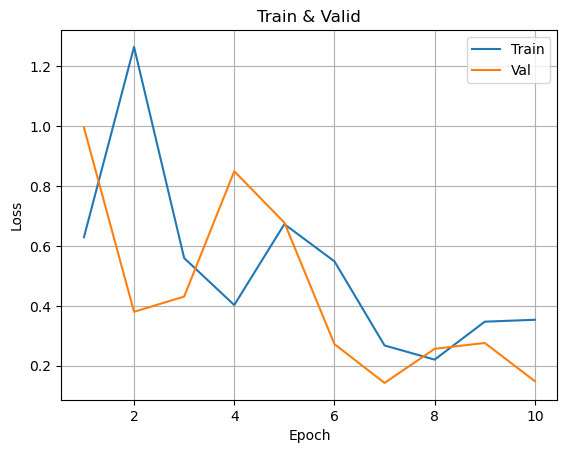

In [727]:
import matplotlib.pyplot as plt

plt.plot(range(1, 11), loss[0], label = 'Train')
plt.plot(range(1, 11), loss[1], label = 'Val')
plt.title("Train & Valid")
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()